# Data Acquisition - Cell Test
## Main Temperature Sensor - Characterization

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df_main_sensor = pd.read_csv("../data/main-temperature-sensor.csv")
df_main_sensor.head()


,timestamp,sensor,termopar,mercurio
0,2025-05-04 16:23:28,2.75,2,4.0
1,2025-05-04 16:24:10,4.25,4,5.0
2,2025-05-04 16:25:25,5.81,5,8.0
3,2025-05-04 16:26:14,7.31,7,8.5
4,2025-05-04 16:26:56,8.56,8,10.0


In [2]:
# Show types and null values
df_main_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  58 non-null     object 
 1   sensor     58 non-null     float64
 2   termopar   58 non-null     object 
 3   mercurio   52 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.9+ KB


In [3]:
df_cleaned = df_main_sensor.copy()

# Change types as float
df_cleaned["termopar"] = pd.to_numeric(df_cleaned["termopar"], errors="coerce")

# Fill in missing values
df_cleaned.ffill(inplace=True)

df_cleaned.info(), df_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  58 non-null     object 
 1   sensor     58 non-null     float64
 2   termopar   58 non-null     float64
 3   mercurio   58 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.9+ KB


(None,
           sensor   termopar   mercurio
 count  58.000000  58.000000  58.000000
 mean   44.565172  44.034483  44.570690
 std    29.594350  29.336502  28.815213
 min    -2.440000   1.000000  -1.500000
 25%    21.167500  20.500000  21.500000
 50%    42.250000  41.500000  42.400000
 75%    69.932500  69.000000  69.625000
 max    93.370000  93.000000  92.000000)

([0, 1, 2],
 [Text(0, 0, 'sensor'), Text(1, 0, 'termopar'), Text(2, 0, 'mercurio')])

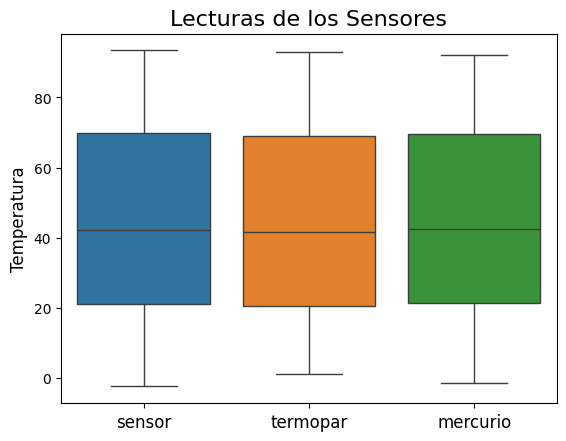

In [4]:
# Search atypic values
sns.boxplot(data=df_cleaned[["sensor", "termopar", "mercurio"]])
plt.title("Lecturas de los Sensores", fontsize=16)
plt.ylabel("Temperatura", fontsize=12)
plt.xticks(fontsize=12)

array([[<Axes: title={'center': 'sensor'}>,
        <Axes: title={'center': 'termopar'}>],
       [<Axes: title={'center': 'mercurio'}>, <Axes: >]], dtype=object)

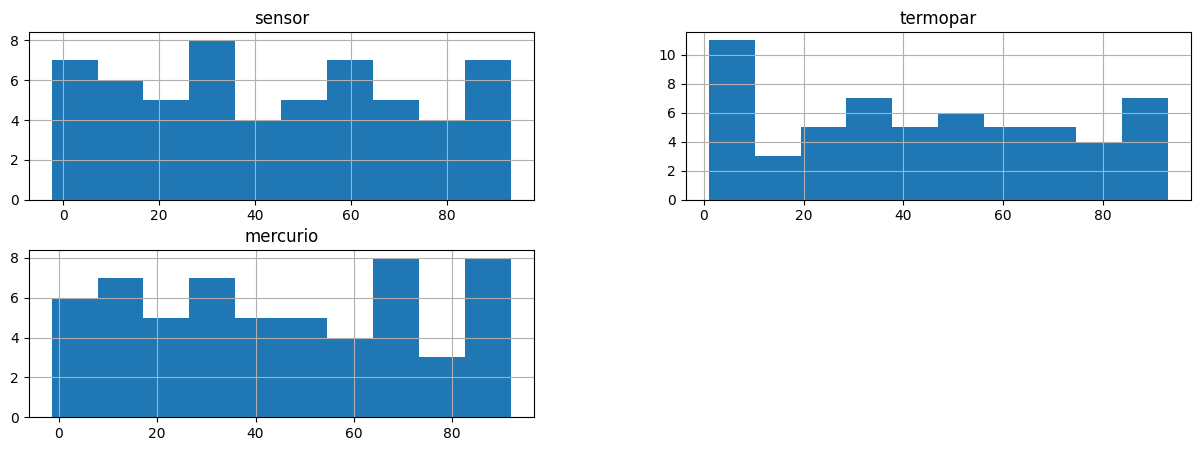

In [5]:
df_cleaned.drop("timestamp", axis=1).hist(bins=10, figsize=(15, 5), grid=True)

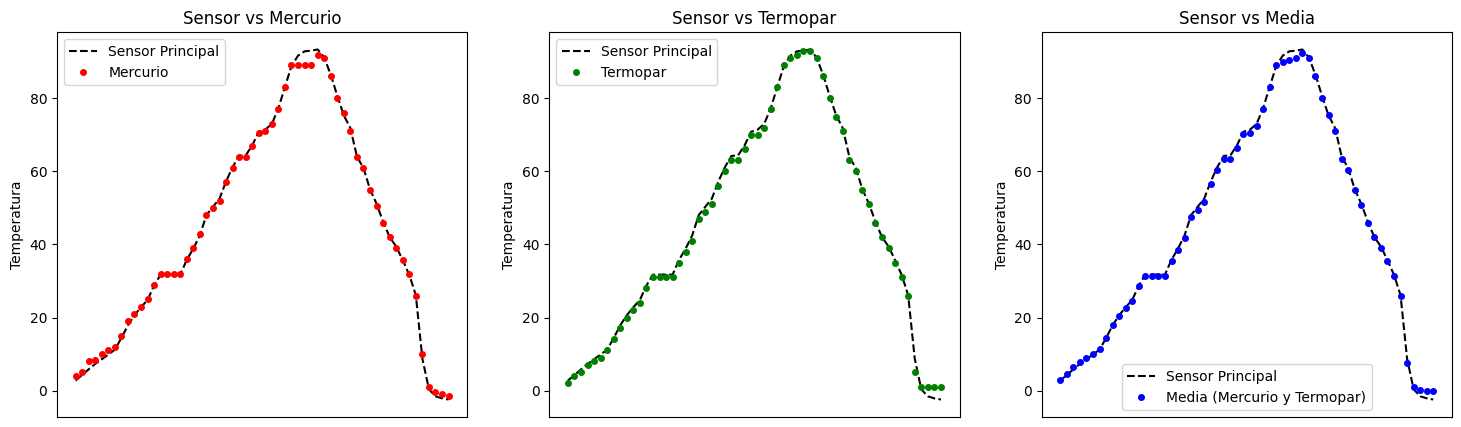

In [6]:
# Sensor vs Termopar and Mercurio

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(df_cleaned["sensor"], label="Sensor Principal", color="black", linestyle="--")
ax1.plot( df_cleaned["mercurio"], label="Mercurio", color="red", marker="o", markersize=4, linestyle="")
ax1.set_title("Sensor vs Mercurio")
ax1.set_ylabel("Temperatura")
ax1.legend()

ax2.plot(df_cleaned["sensor"], label="Sensor Principal", color="black", linestyle="--")
ax2.plot(df_cleaned["termopar"], label="Termopar", color="green", marker="o", markersize=4, linestyle="")
ax2.set_title("Sensor vs Termopar")
ax2.set_ylabel("Temperatura")
ax2.legend()


mean_termopar_mercurio = (df_cleaned["termopar"] + df_cleaned["mercurio"])/2
ax3.plot(df_cleaned['sensor'], label='Sensor Principal', color='black', linestyle='--')
ax3.plot(mean_termopar_mercurio, label='Media (Mercurio y Termopar)', color='blue', marker='o', markersize=4, linestyle='')
ax3.set_title('Sensor vs Media')
ax3.set_ylabel('Temperatura')
ax3.legend()

ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax3.xaxis.set_visible(False)


In [7]:
# Error Promedio
error = np.abs((df_cleaned["sensor"] - mean_termopar_mercurio)/df_cleaned["sensor"])*100
error.describe()

count     58.000000
mean       9.916829
std       31.173778
min        0.000000
25%        0.731408
50%        0.954572
75%        1.784880
max      170.270270
dtype: float64

### Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

x = df_cleaned["sensor"].values.reshape(-1, 1)
y = mean_termopar_mercurio.values

# Linear Model
linear_model = LinearRegression()
linear_model.fit(x, y)

pendiente_m = linear_model.coef_[0]
intercepto_b = linear_model.intercept_

print(f"Modelo Lineal: y = {pendiente_m:.4f}x + {intercepto_b:.4f}")

Modelo Lineal: y = 0.9820x + 0.5376


(-0.1, 1.7304658774416137)

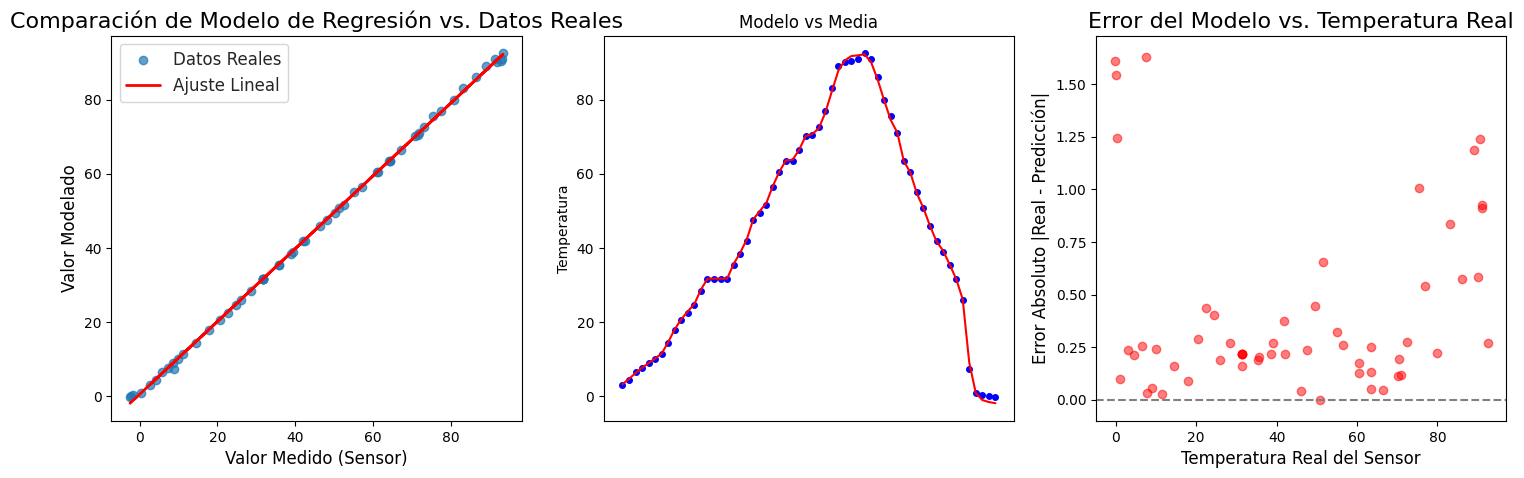

In [9]:
# Model vs Sensor
y_linear_pred = linear_model.predict(x)


# Graficar
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
sns.set_style("whitegrid")

ax1.scatter(x, y, label='Datos Reales', alpha=0.7)
ax1.plot(x, y_linear_pred, color='red', linewidth=2, label='Ajuste Lineal')
ax1.set_title('Comparación de Modelo de Regresión vs. Datos Reales', fontsize=16)
ax1.set_xlabel('Valor Medido (Sensor)', fontsize=12)
ax1.set_ylabel('Valor Modelado', fontsize=12)
ax1.legend(fontsize=12)

ax2.plot(mean_termopar_mercurio, label='Media (Mercurio y Termopar)', color='blue', marker='o', markersize=4, linestyle='')
ax2.plot(y_linear_pred, label='Modelo', color='red', linestyle='-')
ax2.set_title('Modelo vs Media')
ax2.set_ylabel('Temperatura')
ax2.xaxis.set_visible(False)

abs_waste = np.abs(y - y_linear_pred)
ax3.scatter(y, abs_waste, alpha=0.5, color="r")
ax3.axhline(y=0, color='gray', linestyle='--')
ax3.set_title('Error del Modelo vs. Temperatura Real', fontsize=16)
ax3.set_xlabel('Temperatura Real del Sensor', fontsize=12)
ax3.set_ylabel('Error Absoluto |Real - Predicción|', fontsize=12)
ax3.set_ylim(bottom=-0.1, top=max(abs_waste) + 0.1) # Ajustar el eje Y




In [10]:
from sklearn.metrics import max_error, mean_absolute_error, root_mean_squared_error, r2_score

print(f"\x1b[1;34mEvaluacion del Modelo:\x1b[0m \x1b[1;35mf(x) = {pendiente_m:.4f}x + {intercepto_b:.4f}")
print(f"\t\x1b[1;33mError Maximo:\x1b[0m {max_error(y, y_linear_pred):.4f} °C")
print(f"\t\x1b[1;33mError Absoluto Medio (MAE):\x1b[0m {mean_absolute_error(y, y_linear_pred):.4f}")
print(f"\t\x1b[1;33mRaíz del Error Cuadrático Medio (RMSE):\x1b[0m {root_mean_squared_error(y, y_linear_pred):.4f}")
print(f"\t\x1b[1;33mCoeficiente de Determinación (R²):\x1b[0m {r2_score(y, y_linear_pred):.4f}")

Evaluacion del Modelo: f(x) = 0.9820x + 0.5376
	Error Maximo: 1.6305 °C
	Error Absoluto Medio (MAE): 0.4011
	Raíz del Error Cuadrático Medio (RMSE): 0.5746
	Coeficiente de Determinación (R²): 0.9996


## Temperature Sensor - Characterization

In [11]:
df_temperature_sensors = pd.read_csv("../data/temperature-sensors.csv")
df_temperature_sensors.head()

,Pin3,Pin2,Pin4,Pin5,Pin6,Pin7
0,0.58,0.81,0.69,0.81,1,0.75
1,0.52,0.88,0.69,0.75,1.06,0.75
2,0.52,0.81,0.75,0.81,1.06,0.75
3,0.58,0.81,0.75,0.81,1,0.75
4,0.52,0.81,0.75,0.88,1,0.75


In [12]:
df_temperature_sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28349 entries, 0 to 28348
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pin3    28349 non-null  object 
 1   Pin2    28349 non-null  object 
 2   Pin4    28349 non-null  object 
 3   Pin5    28349 non-null  object 
 4   Pin6    28349 non-null  object 
 5   Pin7    28326 non-null  float64
dtypes: float64(1), object(5)
memory usage: 1.3+ MB


In [13]:
df_cleaned = df_temperature_sensors.copy()

# Parsing columns to float
for column in df_cleaned.columns:
    df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors="coerce")

df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28349 entries, 0 to 28348
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pin3    28340 non-null  float64
 1   Pin2    28345 non-null  float64
 2   Pin4    28346 non-null  float64
 3   Pin5    28347 non-null  float64
 4   Pin6    28345 non-null  float64
 5   Pin7    28326 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


In [14]:
df_cleaned.describe()

,Pin3,Pin2,Pin4,Pin5,Pin6,Pin7
count,28340.000000,28345.000000,28346.000000,28347.000000,28345.000000,28326.000000
mean,56.825756,56.021341,55.692765,44.570721,56.097599,56.002083
std,292.209068,21.262113,21.005845,46.952396,21.367330,21.439101
min,-125.990000,0.810000,-127.000000,-127.000000,-127.000000,-127.000000
25%,46.550000,47.380000,47.310000,44.250000,47.630000,47.440000
50%,56.460000,57.440000,57.250000,54.880000,57.560000,57.500000
75%,71.140000,72.440000,71.870000,69.250000,72.500000,72.440000
max,49115.000000,94.000000,86.750000,87.500000,94.000000,87.940000


In [15]:
# Delete error values
df_cleaned[df_cleaned.isin([-127, -125.99])] = np.nan
df_cleaned[df_cleaned > 100] = np.nan

# Generate new values
df_cleaned = df_cleaned.apply(lambda row: row.fillna(row.mean()), axis=1)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28349 entries, 0 to 28348
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pin3    28349 non-null  float64
 1   Pin2    28349 non-null  float64
 2   Pin4    28349 non-null  float64
 3   Pin5    28349 non-null  float64
 4   Pin6    28349 non-null  float64
 5   Pin7    28349 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Pin3'),
  Text(1, 0, 'Pin2'),
  Text(2, 0, 'Pin4'),
  Text(3, 0, 'Pin5'),
  Text(4, 0, 'Pin6'),
  Text(5, 0, 'Pin7')])

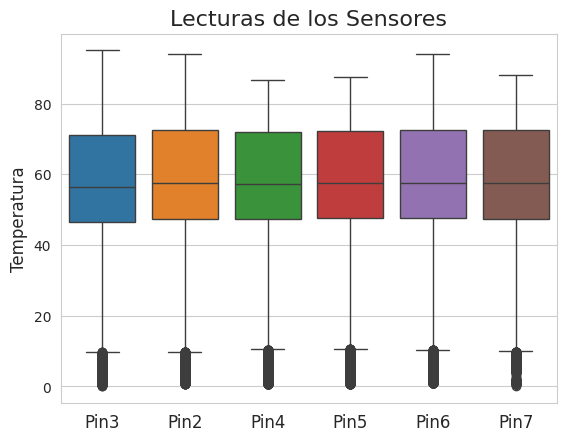

In [16]:
# Search atypic values
sns.boxplot(data=df_cleaned)
plt.title("Lecturas de los Sensores", fontsize=16)
plt.ylabel("Temperatura", fontsize=12)
plt.xticks(fontsize=12)

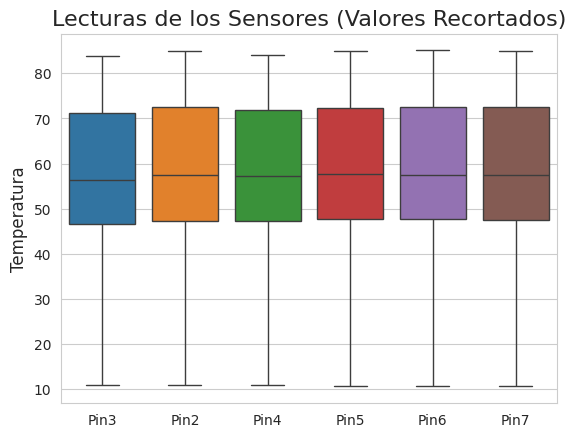

In [17]:
# Winsorization
df_capped = df_cleaned.copy()

for column in df_capped.columns:
    # Calcula el percentil 5 y 95
    p05 = df_capped[column].quantile(0.05)
    p95 = df_capped[column].quantile(0.95)
    
    # Recorta los valores. Todo lo que esté por debajo de p05 se convierte en p05
    # y todo lo que esté por encima de p95 se convierte en p95.
    df_capped[column] = df_capped[column].clip(lower=p05, upper=p95)

sns.boxplot(data=df_capped)
plt.title("Lecturas de los Sensores (Valores Recortados)", fontsize=16)
plt.ylabel("Temperatura", fontsize=12)
plt.show()

In [18]:
df_capped.describe()

,Pin3,Pin2,Pin4,Pin5,Pin6,Pin7
count,28349.000000,28349.000000,28349.000000,28349.000000,28349.000000,28349.000000
mean,55.341338,56.283618,55.933752,56.254866,56.361378,56.279116
std,20.158244,20.472516,20.200676,20.448396,20.531510,20.550461
min,10.920000,10.880000,10.880000,10.750000,10.690000,10.630000
25%,46.550000,47.380000,47.310000,47.630000,47.630000,47.440000
50%,56.460000,57.440000,57.250000,57.630000,57.560000,57.500000
75%,71.140000,72.440000,71.870000,72.370000,72.500000,72.440000
max,83.780000,84.870000,84.120000,84.870000,85.060000,85.000000


array([[<Axes: title={'center': 'Pin3'}>,
        <Axes: title={'center': 'Pin2'}>],
       [<Axes: title={'center': 'Pin4'}>,
        <Axes: title={'center': 'Pin5'}>],
       [<Axes: title={'center': 'Pin6'}>,
        <Axes: title={'center': 'Pin7'}>]], dtype=object)

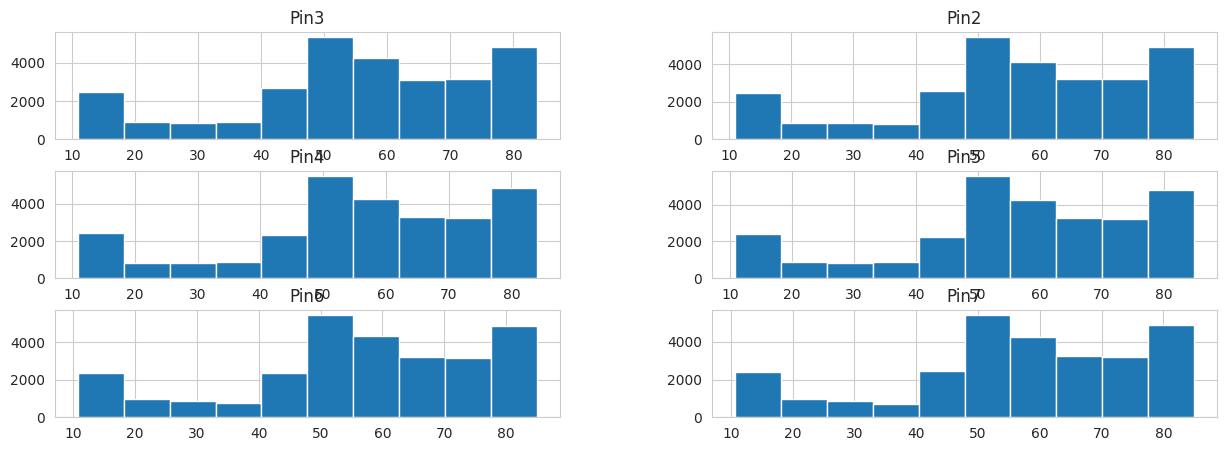

In [19]:
df_capped.hist(bins=10, figsize=(15, 5), grid=True)

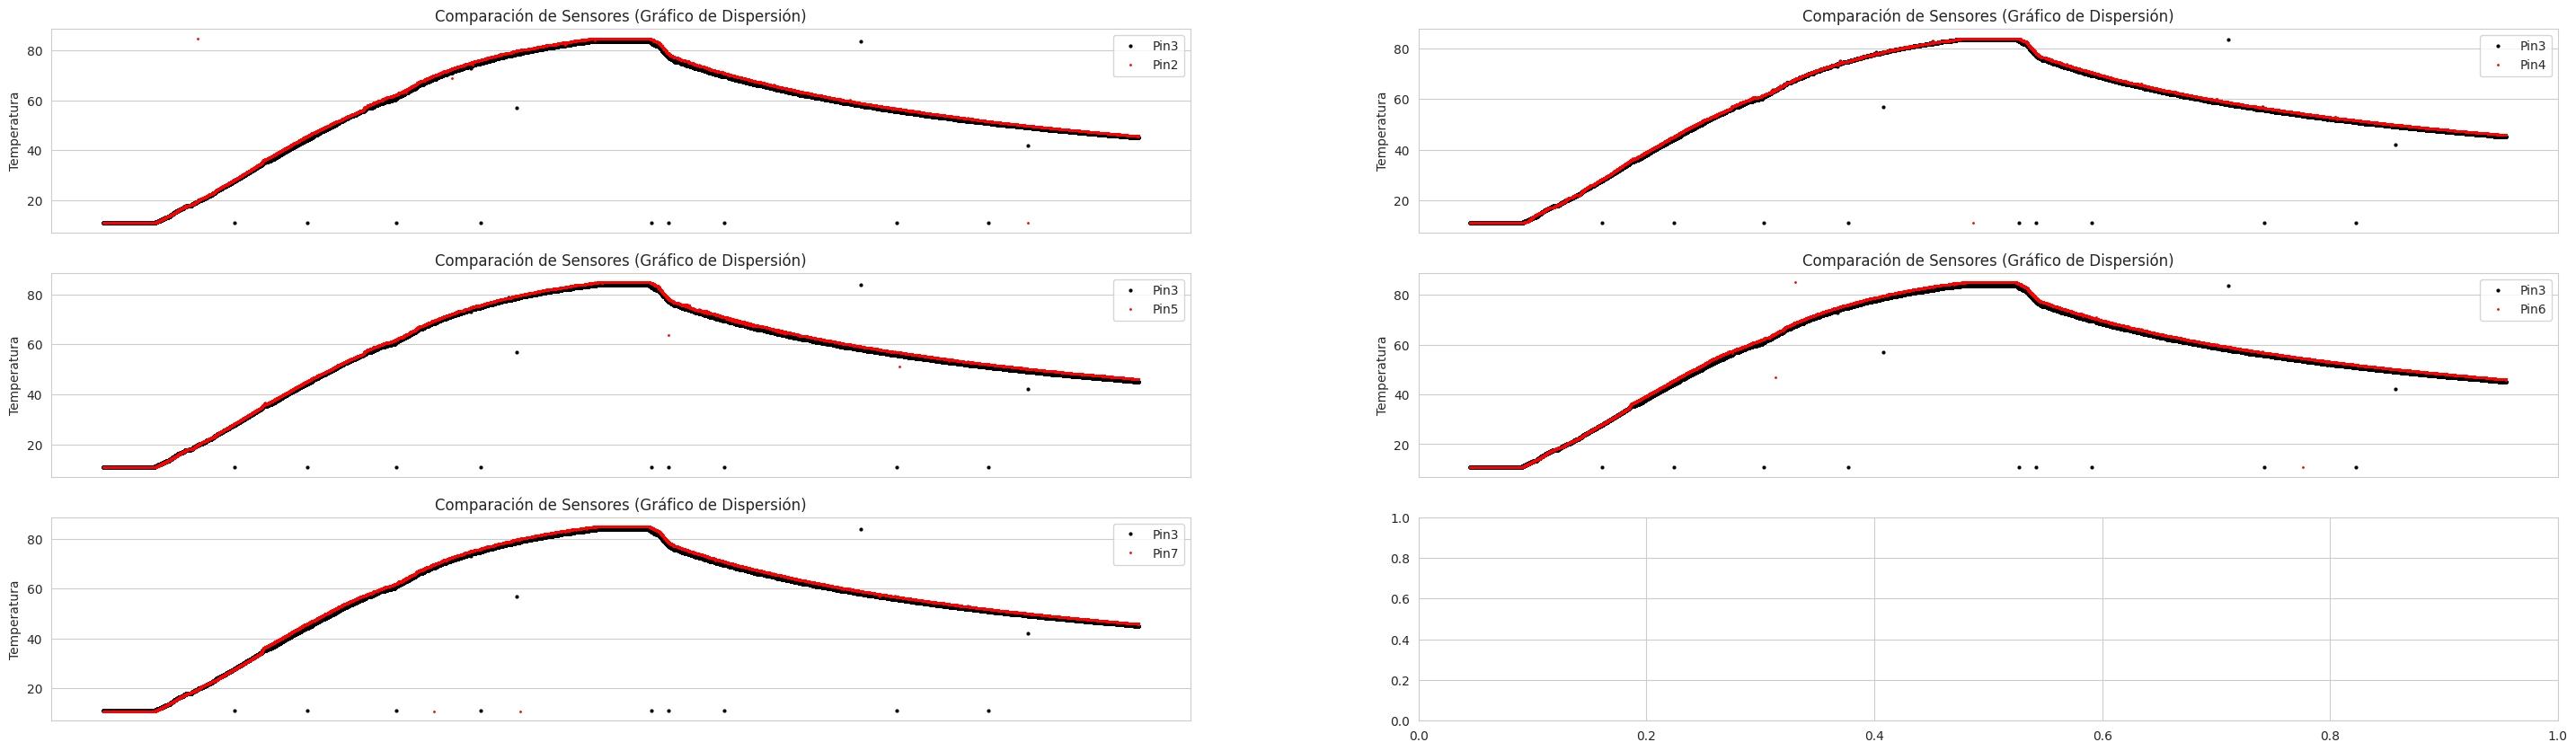

In [20]:
# Caracterizado vs Sensores

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(36, 10))

ax1[0].plot(df_capped["Pin3"], label="Pin3", color="black", marker="o", markersize=2, linestyle="")
ax1[0].plot(df_capped["Pin2"], label="Pin2", color="red", marker=".", markersize=2, linestyle="")
ax1[0].set_title("Comparación de Sensores (Gráfico de Dispersión)")
ax1[0].set_ylabel("Temperatura")
ax1[0].legend()

ax1[1].plot(df_capped["Pin3"], label="Pin3", color="black", marker="o", markersize=2, linestyle="")
ax1[1].plot(df_capped["Pin4"], label="Pin4", color="red", marker=".", markersize=2, linestyle="")
ax1[1].set_title("Comparación de Sensores (Gráfico de Dispersión)")
ax1[1].set_ylabel("Temperatura")
ax1[1].legend()

ax2[0].plot(df_capped["Pin3"], label="Pin3", color="black", marker="o", markersize=2, linestyle="")
ax2[0].plot(df_capped["Pin5"], label="Pin5", color="red", marker=".", markersize=2, linestyle="")
ax2[0].set_title("Comparación de Sensores (Gráfico de Dispersión)")
ax2[0].set_ylabel("Temperatura")
ax2[0].legend()

ax2[1].plot(df_capped["Pin3"], label="Pin3", color="black", marker="o", markersize=2, linestyle="")
ax2[1].plot(df_capped["Pin6"], label="Pin6", color="red", marker=".", markersize=2, linestyle="")
ax2[1].set_title("Comparación de Sensores (Gráfico de Dispersión)")
ax2[1].set_ylabel("Temperatura")
ax2[1].legend()

ax3[0].plot(df_capped["Pin3"], label="Pin3", color="black", marker="o", markersize=2, linestyle="")
ax3[0].plot(df_capped["Pin7"], label="Pin7", color="red", marker=".", markersize=2, linestyle="")
ax3[0].set_title("Comparación de Sensores (Gráfico de Dispersión)")
ax3[0].set_ylabel("Temperatura")
ax3[0].legend()


ax1[0].xaxis.set_visible(False)
ax1[1].xaxis.set_visible(False)
ax2[0].xaxis.set_visible(False)
ax2[1].xaxis.set_visible(False)
ax3[0].xaxis.set_visible(False)


### Linear Regressions

In [21]:
from sklearn.linear_model import LinearRegression

models = []
y = df_capped["Pin3"]

for column in df_capped.drop("Pin3", axis=1).columns:
    x = df_capped[column].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    models.append((column, model))

for name, model in models:
    print(f"{name}: y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}")

Pin2: y = 0.9833x + -0.0001
Pin4: y = 0.9964x + -0.3903
Pin5: y = 0.9847x + -0.0507
Pin6: y = 0.9805x + 0.0778
Pin7: y = 0.9794x + 0.2242


In [22]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


for name, model in models:
    y_pred = model.predict(df_capped[name].values.reshape(-1, 1))
    print(f"\x1b[1;34mEvaluacion del Modelo ({name}):\x1b[0m \x1b[1;35mf(x) = {model.coef_[0]:.4f}x + {model.intercept_:.4f}")
    print(f"\t\x1b[1;33mError Absoluto Medio (MAE):\x1b[0m {mean_absolute_error(y, y_pred):.4f}")
    print(f"\t\x1b[1;33mRaíz del Error Cuadrático Medio (RMSE):\x1b[0m {root_mean_squared_error(y, y_pred):.4f}")
    print(f"\t\x1b[1;33mCoeficiente de Determinación (R²):\x1b[0m {r2_score(y, y_pred):.4f}")

Evaluacion del Modelo (Pin2): f(x) = 0.9833x + -0.0001
	Error Absoluto Medio (MAE): 0.1933
	Raíz del Error Cuadrático Medio (RMSE): 1.0706
	Coeficiente de Determinación (R²): 0.9972
Evaluacion del Modelo (Pin4): f(x) = 0.9964x + -0.3903
	Error Absoluto Medio (MAE): 0.3331
	Raíz del Error Cuadrático Medio (RMSE): 1.1099
	Coeficiente de Determinación (R²): 0.9970
Evaluacion del Modelo (Pin5): f(x) = 0.9847x + -0.0507
	Error Absoluto Medio (MAE): 0.2997
	Raíz del Error Cuadrático Medio (RMSE): 0.9725
	Coeficiente de Determinación (R²): 0.9977
Evaluacion del Modelo (Pin6): f(x) = 0.9805x + 0.0778
	Error Absoluto Medio (MAE): 0.2429
	Raíz del Error Cuadrático Medio (RMSE): 1.0363
	Coeficiente de Determinación (R²): 0.9974
Evaluacion del Modelo (Pin7): f(x) = 0.9794x + 0.2242
	Error Absoluto Medio (MAE): 0.2454
	Raíz del Error Cuadrático Medio (RMSE): 1.1365
	Coeficiente de Determinación (R²): 0.9968


## Voltage Sensor - Characterization

In [23]:
df_voltage = pd.read_csv("../data/voltage-data.csv")
df_voltage.head()

,Voltimetro,SensorRAW,Sensor
0,0.0046,0,0.00
1,3.0230,130,2.97
2,6.0700,262,5.99
3,9.1100,394,9.01
4,12.0500,522,11.94


In [24]:
df_voltage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Voltimetro  9 non-null      float64
 1   SensorRAW   9 non-null      int64  
 2   Sensor      9 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 348.0 bytes


In [25]:
# Testing Different Models

x1 = df_voltage["SensorRAW"].values.reshape(-1, 1)
x2 = df_voltage["Sensor"].values.reshape(-1, 1)
y = df_voltage["Voltimetro"]

from sklearn.linear_model import LinearRegression

model_with_bits = LinearRegression()
model_with_voltage = LinearRegression()


model_with_bits.fit(x1, y)
model_with_voltage.fit(x2, y)

print(f"Model Bits: y = {model_with_bits.coef_[0]:.4f}x + {model_with_bits.intercept_:.4f}")
print(f"Model Voltage: y = {model_with_voltage.coef_[0]:.4f}x + {model_with_voltage.intercept_:.4f}")

Model Bits: y = 0.0231x + 0.0120
Model Voltage: y = 1.0090x + 0.0151


In [26]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


y_pred = model_with_bits.predict(x1)
print(f"\x1b[1;34mEvaluacion del Modelo (Bits):\x1b[0m \x1b[1;35mf(x) = {model_with_bits.coef_[0]:.4f}x + {model_with_bits.intercept_:.4f}")
print(f"\t\x1b[1;33mError Maximo:\x1b[0m {max_error(y, y_pred):.4f} V")
print(f"\t\x1b[1;33mError Absoluto Medio (MAE):\x1b[0m {mean_absolute_error(y, y_pred):.4f}")
print(f"\t\x1b[1;33mRaíz del Error Cuadrático Medio (RMSE):\x1b[0m {root_mean_squared_error(y, y_pred):.4f}")
print(f"\t\x1b[1;33mCoeficiente de Determinación (R²):\x1b[0m {r2_score(y, y_pred):.4f}")

y_pred = model_with_voltage.predict(x2)
print(f"\x1b[1;34mEvaluacion del Modelo (Voltaje):\x1b[0m \x1b[1;35mf(x) = {model_with_voltage.coef_[0]:.4f}x + {model_with_voltage.intercept_:.4f}")
print(f"\t\x1b[1;33mError Maximo:\x1b[0m {max_error(y, y_pred):.4f} V")
print(f"\t\x1b[1;33mError Absoluto Medio (MAE):\x1b[0m {mean_absolute_error(y, y_pred):.4f}")
print(f"\t\x1b[1;33mRaíz del Error Cuadrático Medio (RMSE):\x1b[0m {root_mean_squared_error(y, y_pred):.4f}")
print(f"\t\x1b[1;33mCoeficiente de Determinación (R²):\x1b[0m {r2_score(y, y_pred):.4f}")

Evaluacion del Modelo (Bits): f(x) = 0.0231x + 0.0120
	Error Maximo: 0.0148 V
	Error Absoluto Medio (MAE): 0.0083
	Raíz del Error Cuadrático Medio (RMSE): 0.0095
	Coeficiente de Determinación (R²): 1.0000
Evaluacion del Modelo (Voltaje): f(x) = 1.0090x + 0.0151
	Error Maximo: 0.0165 V
	Error Absoluto Medio (MAE): 0.0094
	Raíz del Error Cuadrático Medio (RMSE): 0.0108
	Coeficiente de Determinación (R²): 1.0000
